<a name='1'></a>
## Packages ##

First, let's run the cell below to import all the packages that we will need during our project. 
- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test our model with our own picture at the end.

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## Problem Set ##

We have a dataset ("data.h5") containing:
* a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
* a test set of m_test images labeled as cat or non-cat
* each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).


In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).


y = [0], it's a 'non-cat' picture.


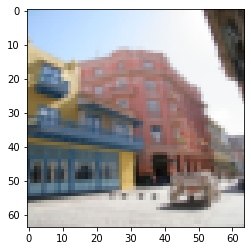

In [5]:
# Example of a picture
index = 23
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [6]:
m_train= train_set_x_orig.shape[0]
m_test= test_set_x_orig.shape[0]
num_px= train_set_x_orig.shape[1] 

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we will now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. 


In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize our dataset, meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

In [8]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<a name='4'></a>
## Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

We will build 1-3 separately and integrate them into one function we call `model()`.

In [9]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    s=1/(1+np.exp(-z))
    
    return s

In [10]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid_test(sigmoid)

sigmoid([0, 2]) = [0.5        0.88079708]
All tests passed!


In [11]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)


[0.62245933 0.5        0.88079708]


In [12]:
def initialize_with_zeros(dim):
    w=np.zeros((dim,1))
    b=0.0
    return w, b

In [13]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

initialize_with_zeros_test(initialize_with_zeros)

w = [[0.]
 [0.]]
b = 0.0
All tests passed!


In [14]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = 1/(1+np.exp(-(np.dot(w.T,X)+b)))
    cost = (-1/m)*np.sum(((Y*np.log(A)) + ((1-Y)*np.log(1-A))))
 
    # BACKWARD PROPAGATION (TO FIND GRAD)
    
    dw = 1 / m * np.dot(X,(A - Y).T)
    db = 1 / m * np.sum((A - Y))
    

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [15]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

propagate_test(propagate)

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405
All tests passed!


<a name='4-4'></a>
### Optimization
- We have initialized our parameters.
- We are also able to compute a cost function and its gradient.
- Now, we want to update the parameters using gradient descent.

In [16]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []
    for i in range(num_iterations):
        grads,cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w-(learning_rate*dw)
        b = b-(learning_rate*db)
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

optimize_test(optimize)

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]
All tests passed!


<a name='ex-7'></a>
### Predict
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Now we will implement the `predict()` function. 

In [18]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = 1/(1+np.exp(-(np.dot(w.T,X)+b)))  
   
    for i in range(A.shape[1]):
        if A[0,i]>0.5:
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
    return Y_prediction

In [19]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predict_test(predict)

predictions = [[1. 1. 0.]]
All tests passed!


<a name='5'></a>
## 5 - Merging all functions into a model ##

Now we will see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [20]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w,b=initialize_with_zeros(X_train.shape[0])
    params,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    w=params["w"]
    b=params["b"]
    
    Y_prediction_test=predict(w,b,X_test)
    Y_prediction_train=predict(w,b,X_train)
 
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [21]:
from public_tests import *

model_test(model)

All tests passed!


After passing all the tests, we will run the following cell to train our model.

In [22]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment**: Training accuracy is close to 100%. This is a good sanity check: our model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. 

y = 1, you predicted that it is a "cat" picture.


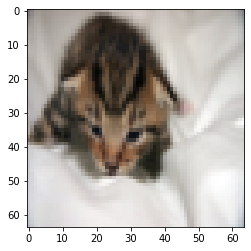

In [23]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

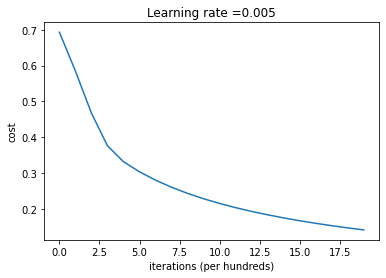

In [24]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

**Interpretation**:
We can see the cost decreasing. It shows that the parameters are being learned. However, we see that we could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

#### Choice of learning rate ####

In order for Gradient Descent to work we must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates.

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



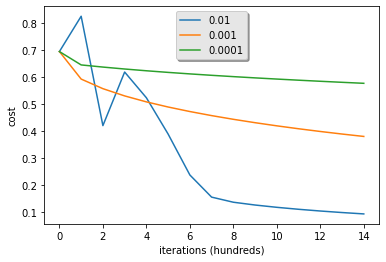

In [35]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, it is usually recommended that we: 
    - Choose the learning rate that better minimizes the cost function.
    - If our model overfits, use other techniques to reduce overfitting.

y = 1.0, your algorithm predicts a "cat" picture.


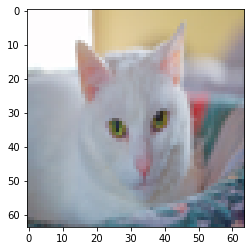

In [26]:
my_image = "my_image2.jpg"   

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


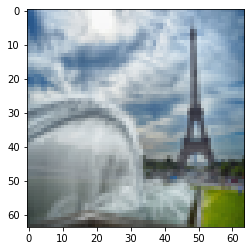

In [27]:
my_image = "my_image.jpg"   

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")